Grid search is a common way to find hyperparameters of a ML model. In principle, there is no way to converge to a ideal set of hyperparameters as grid search follows as a hit-and-trial approach.

The Tree-Structured Parzen Estimator (TPE) is a Bayesian Optimization technique. This means it allows us to start with a initial set of beliefs (aka priors) about what the best set of hyperparameters are, and update these beliefs in a principled way as we learn how different hyperparameters impact model performance.

TPE gets its name from the two main ideas its based on:

1. Using Parzen estimation to model our beliefs about the best hyperparameters.
2. Using a tree-like data structure called posterior-inference graph to optimize algorithm runtime.

### Setting up a toy problem

In [1]:
import numpy as np

np.random.seed(1)
x = np.linspace(0, 100, 1000)
m = np.random.randint(0, 100)
b = np.random.randint(-5000, 5000)
noise = np.random.randn(1000)*700
y = m*x + b + noise

Text(0, 0.5, 'y')

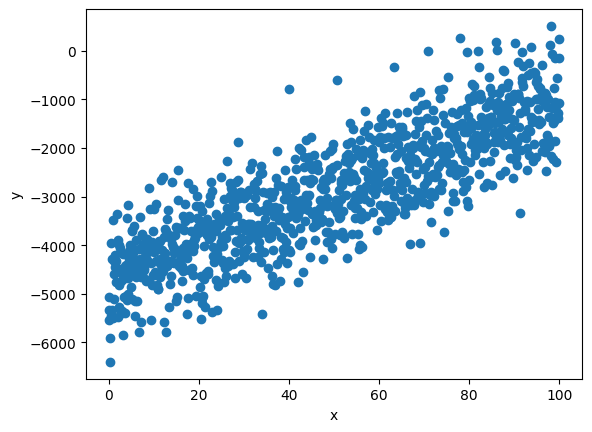

In [2]:
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')

Since TPE is an optimization parameter, we need some metric to optimize over. Lets use the root mean squared error (RMSE).

In [3]:
def rmse(m, b):
    preds = m*x + b
    return np.sqrt(((y-preds)**2).sum()/len(preds))

Next, we'll define our priors (initial beliefs) about the hyperparameters. Let's say we believe that the slope of the best-fit line is a uniform random variable between (10, 100) and the intercept is a uniform random variable between (-6000, -3000). (That they are uniform random variables is equivalent to saying that we believe they are equally likely to lie in their respective intervals).

In [4]:
class UniformDist:

    def __init__(self, min_, max_):
        self.min = min_
        self.max = max_

    def sample(self, n_samples):
        return np.random.uniform(self.min, self.max, n_samples)

search_space = {'m' : UniformDist(10, 100), 'b' : UniformDist(-6000, -3000)}

Now, let's begin implementing the algorithm.

### Step 1: Random Exploration

The first step of TPE is to randomly sample sets of hyperparameters from our priors. This process gives us a first approximation of where the areas of our search space are that produce good models. The function `sample_priors` consumes our initial search space and a number of random samples to draw from it. It then evaluates the resulting models using our objective function `rmse` and returns a Pandas DataFrame containing the slope, intercept, and RMSE of each trial.

In [5]:
import pandas as pd
def sample_priors(space, n_samples):
    seed = np.array([space[hp].sample(n_samples) for hp in space])
    seed_rmse = np.array([rmse(m, b) for m, b in seed.T])
    data = np.stack([seed[0], seed[1], seed_rmse]).T
    trials = pd.DataFrame(data, columns=['m', 'b', 'rmse'])

    return trials

### Step 2: Partitioning the search space and Parzen Estimation

After generating some initial samples from our priors, we now split our hyperparameter search space in two using a quantile threshold γ, where γ is between 0 and 1. Let’s arbitrarily choose γ=0.2. Hyperparameter combinations which result in a model that performs in the top 20% of all models we have created thus far get grouped into a “good” distribution l(x). All other hyperparameter combinations belong to a “bad” distribution g(x).

It turns out that the best next combination of our hyperparameters to test is given by the maximum of g(x)/l(x). This intuitively makes sense. We want hyperparameters which are highly likely under our “good” distribution l(x) and not very likely under our “bad” distribution g(x). We can model each of g(x) and l(x) using Parzen Estimators which is where the “PE” in “TPE” comes from. The rough idea of Parzen Estimation a.k.a. Kernel Density Estimation (or KDE) is that we are going to average across a series of normal distributions each centered on an observation belonging to g(x) or l(x) (respectively). The resulting distributions have high density over regions of our search space where samples are close together and low density over regions where samples are far apart.

In [6]:
from sklearn.neighbors import KernelDensity

def segment_distributions(trials, gamma):
    cut = np.quantile(trials['rmse'], gamma)

    l_x = trials[trials['rmse'] < cut][['m', 'b']]
    g_x = trials[~trials.isin(l_x)][['m', 'b']].dropna()

    l_kde = KernelDensity(kernel='gaussian', bandwidth=5.0)
    g_kde = KernelDensity(kernel='gaussian', bandwidth=5.0)

    l_kde.fit(l_x)
    g_kde.fit(g_x)

    return l_kde, g_kde

Notice that TPE, a hyperparameter optimization algorithm, itself has a hyperparameter γ (meta !!).

### Step 3: Determining the next best hyperparameters to test

As mentioned in Step 2, the next best set of hyperparameters to test maximize g(x)/l(x). We can determine what this set of hyperparameters are in the following way. First we draw N random samples from l(x). Then for each of those samples we evaluate their log-likelihood with respect to l(x) and g(x), selecting the sample which maximizes g(x)/l(x) as the next hyperparameter combination to test.

In [7]:
def choose_next_hps(l_kde, g_kde, n_samples):
    samples = l_kde.sample(n_samples)

    l_score = l_kde.score_samples(samples)
    g_score = g_kde.score_samples(samples)

    hps = samples[np.argmax(g_score/l_score)]

    return hps

### Putting everything together

In [8]:
def tpe(space, n_seed, n_total, gamma):
    '''
    Consumes a hyperparameter search space, number of iterations for seeding
    and total number of iterations and performs Bayesian Optimization. TPE
    can be sensitive to choice of quantile cutoff, which is controlled with gamma.
    '''

    #Seed priors
    trials = sample_priors(space, n_seed)

    for i in range(n_seed, n_total):

        #Segment trials into l and g distributions
        l_kde, g_kde = segment_distributions(trials, gamma)

        #Determine next pair of hyperparameters to test
        hps = choose_next_hps(l_kde, g_kde, 100)

        #Evaluate with rmse and add to trials
        result = np.concatenate([hps, [rmse(hps[0], hps[1])]])

        trials = trials.append(
            {col:result[i] for i, col in enumerate(trials.columns)},
            ignore_index=True
        )

    return trials

### Applying TPE on our toy problem

In [9]:
np.random.seed(1)
search_space = {'m':UniformDist(10,100), 'b':UniformDist(-6000,-3000)}

df = tpe(search_space,
         n_seed=30,
         n_total=200,
         gamma=.2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
<ipython-input-8-7f119e24b642>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trials = trials.append(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
<ipython-input-8-7f119e24b642>:22: FutureWarning: The frame.append method is deprecated and will be re

In [10]:
m_lr, b_lr = np.polyfit(x, y, deg=1)
m_lr, b_lr

(36.50574316544439, -4710.020632073527)

In [11]:
m_tpe = df[df['rmse'] == min(df['rmse'])]['m'].values[0]
b_tpe = df[df['rmse'] == min(df['rmse'])]['b'].values[0]

In [12]:
m_tpe, b_tpe

(29.60557128419024, -4247.563467052864)

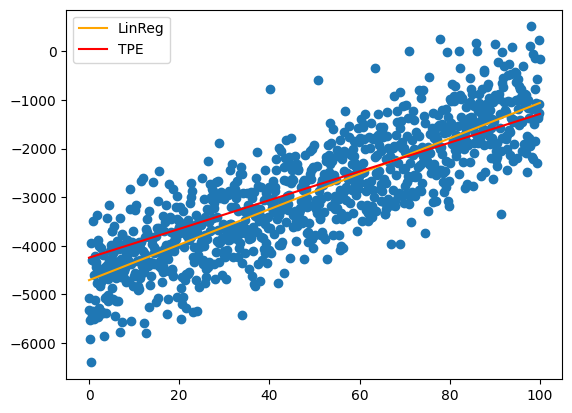

In [13]:
plt.scatter(x, y)
plt.plot(x, m_lr*x + b_lr, color='orange', label='LinReg')
plt.plot(x, m_tpe*x + b_tpe, color='red', label='TPE')
plt.legend()

The line obtained using TPE is very close to the line of best fit. Obviously, we can't expect the TPE line to outperform the line of best fit obtained using a linear regression model, as linear regression has a closed form solution.